This is an initial step to ensure toggle key is enabled on all cells

In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

Reading libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import optimize

import pandas as pd
import datetime as dt

import seaborn as sns

hide_toggle()

Read from URL and convert to long for confirmed cases. This is currently not set-up to read from the storage. Plan in next update of notebook

In [3]:
url_confirmed="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
url_fatalities = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
url_recovered = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"

raw_data_confimed=pd.read_csv(url_confirmed)
raw_data_fatalities = pd.read_csv(url_fatalities)
raw_data_recovered = pd.read_csv(url_recovered)

hide_toggle()

This is a conversion from wide to long. The datasets are timeseries datasets, with dates in column names, which isn't the most convenient format. 

In [4]:
val_cols = list(raw_data_confimed.columns)

raw_data_confimed_long = pd.melt(raw_data_confimed, id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
        value_vars=val_cols[4:], value_name="ConfirmedCases", var_name="Date")
raw_data_fatalities_long = pd.melt(raw_data_fatalities, id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
        value_vars=val_cols[4:], value_name="Fatalities", var_name="Date")
raw_data_recovered_long = pd.melt(raw_data_recovered, id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
        value_vars=val_cols[4:], value_name="Recovered", var_name="Date")

hide_toggle()

Some columns being renamed with change of special characters to work with the previous versions of code 

In [5]:
raw_data_confimed_long.columns = raw_data_confimed_long.columns.str.replace("/", "_")
raw_data_fatalities_long.columns = raw_data_fatalities_long.columns.str.replace("/", "_")
raw_data_recovered_long.columns = raw_data_recovered_long.columns.str.replace("/", "_")

hide_toggle()

Initial data read-in. This is currently using API (https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)

In [6]:
initial_import_confirmed = pd.DataFrame(raw_data_confimed_long.drop(columns=['Lat','Long']))
initial_import_fatalities = pd.DataFrame(raw_data_fatalities_long.drop(columns=['Lat','Long']))
initial_import_recovered = pd.DataFrame(raw_data_recovered_long.drop(columns=['Lat','Long']))
#pd.read_csv('data/data_raw.csv')



hide_toggle()

Combining the recovered, fatalities and confirmed cases into a single data frame

In [7]:
initial_import_conf_fatality = pd.merge(initial_import_confirmed, initial_import_fatalities, on=['Province_State', 'Country_Region','Date'])
#initial_import_conf_fatality['Date']=pd.to_datetime(initial_import_conf_fatality['Date'])

initial_import = pd.merge(initial_import_conf_fatality, initial_import_recovered, on = ['Province_State', 'Country_Region','Date'])
initial_import['Date']=pd.to_datetime(initial_import['Date'])

hide_toggle()

First Cut Processing, calculating the total cases for a country and extracting a minimum date to calculate days from onset

In [8]:
subset = initial_import[initial_import.ConfirmedCases !=0]

min_date = pd.DataFrame(subset.groupby(['Country_Region'])['Date'].min())

total_cases = pd.DataFrame(subset.groupby(['Country_Region','Date'])['ConfirmedCases'].sum())

total_fatality = pd.DataFrame(subset.groupby(['Country_Region','Date'])['Fatalities'].sum())

total_recoveries = pd.DataFrame(subset.groupby(['Country_Region','Date'])['Recovered'].sum())

total_cases.reset_index(inplace=True)
min_date.reset_index(inplace=True)
total_fatality.reset_index(inplace=True)

total_recoveries.reset_index(inplace=True)

hide_toggle()


Start calculating the day of onset. 

In [9]:
total_cases_minimum_date = pd.merge(total_cases, min_date, on = ['Country_Region'])
total_cases_minimum_date.rename(columns = {'Date_y':'onset_date', 'Date_x':'Date'}, inplace=True)

train_subset_minimum_date = pd.merge(total_cases_minimum_date, total_fatality, on = ['Country_Region', 'Date'])

train_subset_minimum_date = pd.merge(train_subset_minimum_date, total_recoveries, on =['Country_Region','Date'])
train_subset_minimum_date['days_from_onset']= (pd.to_datetime(train_subset_minimum_date['Date'])-
                                               pd.to_datetime(train_subset_minimum_date['onset_date'])).dt.days

hide_toggle()

In [11]:
#train_subset_minimum_date.to_csv('export_base.csv')

Exploring specific country behaviors - sample before slope calculations

In [10]:
country_list = ['India','United Kingdom','China','Japan','Korea, South', 'Italy', 'Germany', 'US', 'Spain', 'Mali']

hide_toggle()

In [11]:
exponential_test = train_subset_minimum_date.loc[train_subset_minimum_date['Country_Region'].isin(country_list)]

exponential_test_subset = exponential_test.loc[exponential_test['ConfirmedCases']>100]
exponential_test_subset['days_from_onset'] = exponential_test_subset.groupby('Country_Region')['days_from_onset'].transform(lambda x: (x - x.min()) )

hide_toggle()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


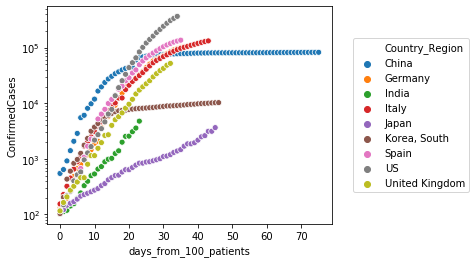

In [12]:
grid = sns.scatterplot(x='days_from_onset', y='ConfirmedCases', data = exponential_test_subset, hue = 'Country_Region')
grid.set( yscale="log")
box = grid.get_position()
grid.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
grid.legend(loc='center right', bbox_to_anchor=(1.50, 0.5), ncol=1)

grid.set(xlabel = 'days_from_100_patients')
plt.show()

hide_toggle()

In [13]:
exponential_test_subset['daily_change']=exponential_test_subset.groupby('Country_Region')['ConfirmedCases'].diff(periods=1)

hide_toggle()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Almost all countries have exponential rate which can be seen below where DN is seen proportional to the number of cases

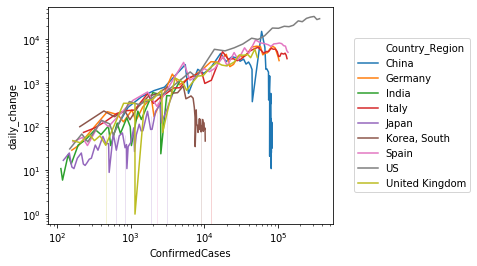

In [14]:
grid = sns.lineplot(x='ConfirmedCases', y='daily_change', data = exponential_test_subset.dropna(), hue = 'Country_Region')
grid.set( yscale="log", xscale="log")
box = grid.get_position()
grid.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
grid.legend(loc='center right', bbox_to_anchor=(1.50, 0.5), ncol=1)

#grid.set(xlabel = 'days_from_100_patients')
plt.show()

hide_toggle()

Calculating the log slope and accuracy of it's fit

In [15]:
from scipy.stats import linregress

country_list = list(initial_import.loc[initial_import['ConfirmedCases']>100]['Country_Region'].unique())

slope_data = pd.DataFrame({'country': [], 'slope': [], 'accuracy': []})

for country in (country_list):
    #print(country)
    fit_data = train_subset_minimum_date.loc[train_subset_minimum_date['Country_Region']==country]
    #fit_data = fit_data.loc[fit_data['ConfirmedCases']>100]
    fit_data['days_from_onset'] = fit_data.groupby('Country_Region')['days_from_onset'].transform(lambda x: (x - x.min()) )

    slope, intercept, r_value, p_value, std_err = linregress(fit_data['days_from_onset'],np.log(fit_data['ConfirmedCases']+1))
    slope_data = slope_data.append({'country': country, 'slope': slope, 'accuracy': r_value}, ignore_index=True)
    #print(country,slope,r_value)

hide_toggle()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Checking which countries have low accuracy of fit. it looks like most countries have reasonably high accuracy.. ~0.8 or higher

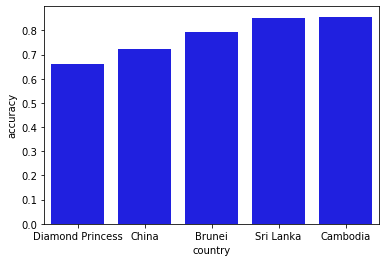

In [16]:
slope_data['accuracy']=round(slope_data['accuracy'],3)

grid = sns.barplot(data = slope_data.sort_values('accuracy', ascending=True).head(5), 
                   y='accuracy', x='country',color = 'blue')

hide_toggle()

Have we seen the worst already? Which countries have high slopes but aren't marked in earlier plots or are not getting highlighted in global coverage. 

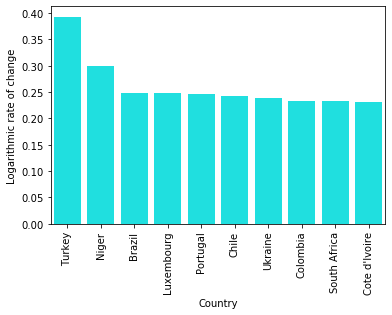

In [17]:
grid = sns.barplot(data = slope_data.sort_values('slope', ascending=False).head(10), 
                   y='slope', x='country',color = 'cyan')

grid.set(xlabel = 'Country', ylabel = 'Logarithmic rate of change')

loc, labels = plt.xticks()

grid.set_xticklabels(labels, rotation=90)
plt.show()


hide_toggle()

In [18]:
high_slope_countries = list(pd.DataFrame(slope_data.sort_values('slope', ascending=False).head(10))['country'])

hide_toggle()

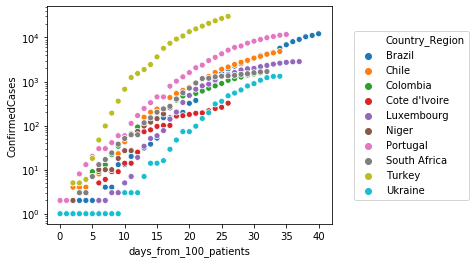

In [19]:
grid = sns.scatterplot(x='days_from_onset', y='ConfirmedCases', 
                       data = train_subset_minimum_date.loc[train_subset_minimum_date['Country_Region'].isin(high_slope_countries)],
                       hue = 'Country_Region')
grid.set( yscale="log")
box = grid.get_position()
grid.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
grid.legend(loc='center right', bbox_to_anchor=(1.50, 0.5), ncol=1)

grid.set(xlabel = 'days_from_100_patients')
plt.show()

hide_toggle()

World data calculation

In [21]:
world_data = train_subset_minimum_date.drop(columns=['onset_date','days_from_onset','Country_Region'])

world_data_calculated = world_data.groupby('Date').sum()

world_data_calculated.reset_index(inplace=True)

world_data_calculated['days_from_onset']=(world_data_calculated['Date']-world_data_calculated['Date'].min()).dt.days

world_data_calculated.drop(columns='Date', inplace=True)

world_data_calculated['InfectedCases']=world_data_calculated['ConfirmedCases']-world_data_calculated['Recovered']-world_data_calculated['Fatalities']

hide_toggle()

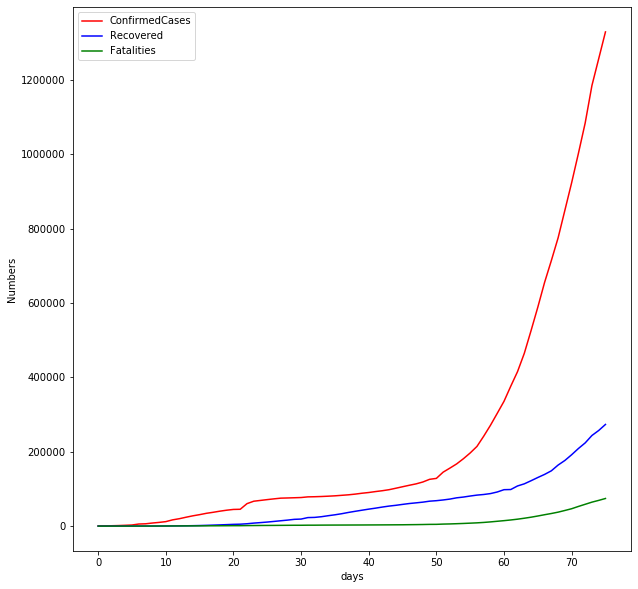

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
sns.lineplot(x='days_from_onset', 
             y='ConfirmedCases',
             color='r',
             ax=ax, data = world_data_calculated)
sns.lineplot(x='days_from_onset', 
             y='Recovered', 
             color='b',
             ax=ax, data = world_data_calculated)
sns.lineplot(x='days_from_onset', 
             y='Fatalities', 
             color='g',
             ax=ax, data = world_data_calculated)

ax.legend(['ConfirmedCases', 'Recovered','Fatalities'], facecolor='w')

ax.set(xlabel='days', ylabel='Numbers')

plt.show()

hide_toggle()

SIR modeling fitting

In [23]:
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy import optimize

hide_toggle()

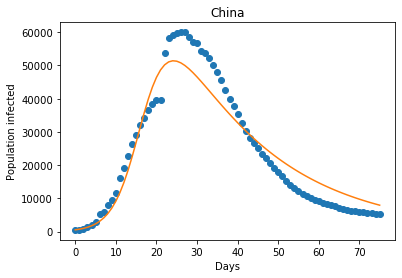

Spread Variable = 0.337  and recovery variable =  0.04113
Assumed total population impacted 82665.0


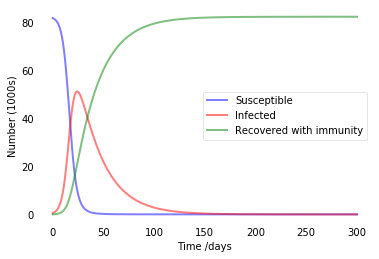

In [24]:
sir_country = "China"

sir_data = train_subset_minimum_date.loc[train_subset_minimum_date['Country_Region']==sir_country]

# Population - this will need to be tied into another API, currently a manual input
N = sir_data['ConfirmedCases'].max()*1.0

# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = sir_data['ConfirmedCases'].min(), sir_data['Recovered'].min()

# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 1, 1./100 

# A grid of time points (in days)
t = np.linspace(0, 300, 300)

# The SIR model differential equations.
def sir_model(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0

# Integrate the SIR equations over the time grid, t.
#ret = odeint(sir_model, y0, t, args=(beta, gamma))
#S, I, R = ret.T

# Use a function to 
def fit_odeint(x, beta, gamma):
    return odeint(sir_model, (S0, I0, R0), x, args=(beta, gamma))[:,1]

ydata=np.array(sir_data['ConfirmedCases']) - np.array(sir_data['Recovered'])#, np.array(sir_data['ConfirmedCases'])
xdata=np.array(sir_data['days_from_onset'])


popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata, bounds=((0, 0), (np.inf, 0.1)))
fitted = fit_odeint(xdata, *popt)

ret = odeint(sir_model, y0, t, args=(popt[0], popt[1]))
S, I, R = ret.T

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title(sir_country)
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Spread Variable =", round(popt[0],3), " and recovery variable = ", round(popt[1],5))
print("Assumed total population impacted", N)

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
#ax.plot(t, F/1000, 'y', alpha=1, lw=2, label='Deceased')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
#ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

hide_toggle()

SIR modeling - simulation

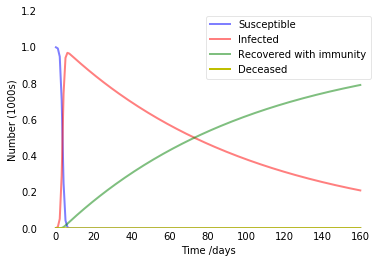

In [25]:
# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0, F0 = 1, 0, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0 - F0

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days) 
# and chi is the number of deaths due to disease per day.https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4552173/
beta, gamma, chi = 2, 1./100, 1/1000 



# A grid of time points (in days)
t = np.linspace(0, 160, 160)



# The SIR model differential equations.
def sird_model(y, t, beta, gamma, chi):
    S, I, R, F = y
    dSdt = -beta * S * I / N 
    dIdt = beta * S * I / N - gamma * I
    dFdt = gamma*chi*I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt, dFdt

# Initial conditions vector
y0 = S0, I0, R0, F0

# Integrate the SIR equations over the time grid, t.
ret = odeint(sird_model, y0, t, args=(beta, gamma, chi))
S, I, R, F = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.plot(t, F/1000, 'y', alpha=1, lw=2, label='Deceased')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

hide_toggle()

SIRDS modeling

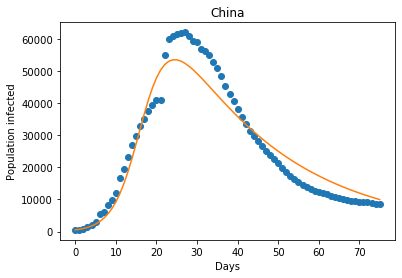

spread Variable = 0.334  and recovery variable =  0.03699
fatality Variable = 0.041
Assumed total population impacted 82665.0


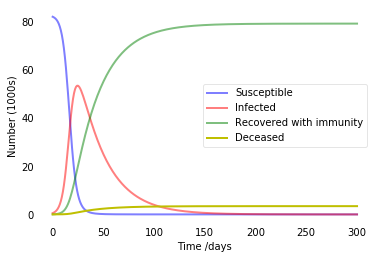

In [26]:
sir_country = "China"

sir_data = train_subset_minimum_date.loc[train_subset_minimum_date['Country_Region']==sir_country]

# Population - this will need to be tied into another API, currently a manual input
N0 = sir_data['ConfirmedCases'].max()*1.0

# Initial number of infected and recovered individuals, I0 and R0.
I0, R0, F0 = sir_data['ConfirmedCases'].min(), sir_data['Recovered'].min(), sir_data['Fatalities'].min()

fatality_upper_limit = (sir_data['Fatalities'].max())/(sir_data['Fatalities'].max()+sir_data['Recovered'].max())

# Everyone else, S0, is susceptible to infection initially.
S0 = N0 - I0 - R0 - F0

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days), fatality rate.
beta, gamma, f = 1, 1./100, 0.05 

# A grid of time points (in days)
t = np.linspace(0, 300, 300)

# The SIR model differential equations.
def sird_model(y, t, beta, gamma, f):
    S, I, R, F = y
    N = N0-F
    dSdt = -beta * S * I / N 
    dIdt = beta * S * I / N - gamma * I
    dFdt = gamma*f*I
    dRdt = (1-f)*gamma * I 
    return dSdt, dIdt, dRdt, dFdt

# Initial conditions vector
y0 = S0, I0, R0, F0

# Integrate the SIR equations over the time grid, t.
#ret = odeint(sir_model, y0, t, args=(beta, gamma))
#S, I, R = ret.T

# Use a function to 
def fit_odeint(x, beta, gamma, f):
    return odeint(sird_model, (S0, I0, R0, F0), x, args=(beta, gamma, f))[:,1]

ydata=np.array(sir_data['ConfirmedCases']) - np.array(sir_data['Recovered'] -np.array(sir_data['Fatalities']))#, np.array(sir_data['ConfirmedCases'])
xdata=np.array(sir_data['days_from_onset'])


popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata, bounds=((0, 0, 0), (np.inf, np.inf, fatality_upper_limit)))
fitted = fit_odeint(xdata, *popt)

ret = odeint(sird_model, y0, t, args=(popt[0], popt[1], popt[2]))
S, I, R, F = ret.T

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title(sir_country)
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("spread Variable =", round(popt[0],3), " and recovery variable = ", round(popt[1],5))
print("fatality Variable =", round(popt[2],3))
print("Assumed total population impacted", N0)

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.plot(t, F/1000, 'y', alpha=1, lw=2, label='Deceased')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
#ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

hide_toggle()

SIRDS converted to function

In [27]:
def sirds_extractor(country):
    sir_data = train_subset_minimum_date.loc[train_subset_minimum_date['Country_Region']==sir_country]
    # Population - this will need to be tied into another API, currently a manual input
    N0 = sir_data['ConfirmedCases'].max()*1.0

    # Initial number of infected and recovered individuals, I0 and R0.
    I0, R0, F0 = sir_data['ConfirmedCases'].min(), sir_data['Recovered'].min(), sir_data['Fatalities'].min()

    fatality_upper_limit = (sir_data['Fatalities'].max())/(sir_data['Fatalities'].max()+sir_data['Recovered'].max())

    # Everyone else, S0, is susceptible to infection initially.
    S0 = N0 - I0 - R0 - F0

    # Contact rate, beta, and mean recovery rate, gamma, (in 1/days), fatality rate.
    beta, gamma, f = 1, 1./100, 0.05 

    # A grid of time points (in days)
    t = np.linspace(0, 300, 300)

    # The SIR model differential equations.
    def sird_model(y, t, beta, gamma, f):
        S, I, R, F = y
        N = (N0-F)
        dSdt = -beta * S * I / N 
        dIdt = beta * S * I / N - gamma * I
        dFdt = gamma*f*I
        dRdt = (1-f)*gamma * I 
        return dSdt, dIdt, dRdt, dFdt

# Initial conditions vector
    y0 = S0, I0, R0, F0

# Integrate the SIR equations over the time grid, t.
#ret = odeint(sir_model, y0, t, args=(beta, gamma))
#S, I, R = ret.T

# Use a function to 
    def fit_odeint(x, beta, gamma, f):
        return odeint(sird_model, (S0, I0, R0, F0), x, args=(beta, gamma, f))[:,1]

    ydata=np.array(sir_data['ConfirmedCases']) - np.array(sir_data['Recovered'] -np.array(sir_data['Fatalities']))#, np.array(sir_data['ConfirmedCases'])
    xdata=np.array(sir_data['days_from_onset'])


    popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata, bounds=((0, 0, 0), (np.inf, np.inf, fatality_upper_limit)))
    fitted = fit_odeint(xdata, *popt)
    
    return popt

hide_toggle()